# Full Bayesian inference using linear approximation of dynamics

In [8]:
import random

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from gMLV import *

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)

# some plotting functions

cols = ["red", "green", "blue", "royalblue","orange", "black", "salmon", "forestgreen", "steelblue", "slateblue","gold", "palegreen"]

def plot_gMLV(yobs, sobs, timepoints):
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    fig, axs = plt.subplots(1, 2)
    for species_idx in range(yobs.shape[1]):
        axs[0].plot(timepoints, yobs[:, species_idx], color=cols[species_idx])
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]')
    if sobs.shape[1] > 0:
        for metabolite_idx in range(sobs.shape[1]):
            axs[1].plot(timepoints, sobs[:, metabolite_idx], color=cols[metabolite_idx])
        axs[1].set_xlabel('time')
        axs[1].set_ylabel('[metabolite]');

def plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, timepoints):
    # plot the fit
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    fig, axs = plt.subplots(1, 2)  
    for species_idx in range(yobs.shape[1]):
        axs[0].plot(timepoints, yobs[:, species_idx], color=cols[species_idx])
        axs[0].plot(timepoints, yobs_h[:, species_idx], '--', color=cols[species_idx])
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]');

    for metabolite_idx in range(sobs.shape[1]):
        axs[1].plot(timepoints, sobs[:, metabolite_idx], color=cols[metabolite_idx])
        axs[1].plot(timepoints, sobs_h[:, metabolite_idx], '--', color=cols[metabolite_idx])
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('[metabolite]');

def compare_params(mu=None, M=None, alpha=None, e=None):
    # each argument is a tuple of true and predicted values
    if mu is not None:
        print("mu_hat/mu:")
        print(np.array(mu[1]))
        print(np.array(mu[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0,len(mu[0]), dtype="int32"), np.array(mu[1]), markerfmt="D")
        ax.stem(np.arange(0,len(mu[0]), dtype="int32"), np.array(mu[0]), markerfmt="X")
        ax.set_xlabel('i')
        ax.set_ylabel('mu[i]');

    if M is not None:
        print("\nM_hat/M:")
        print(np.round(np.array(M[1]), decimals=2))
        print("\n",np.array(M[0]))

        #fig, ax = plt.subplots()
        #ax.stem(np.arange(0, M[0].shape[0] ** 2), np.array(M[1]).flatten(), markerfmt="D")
        #ax.stem(np.arange(0, M[0].shape[0] ** 2), np.array(M[0]).flatten(), markerfmt="X")
        #ax.set_ylabel('M[i,j]');

        fig, ax = plt.subplots()
        Ns = M[0].shape[0]
        ax.stem(np.arange(0, Ns), np.array(M[1]).diagonal(), markerfmt="D")
        ax.stem(np.arange(0, Ns), np.array(M[0]).diagonal(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
        
        fig, ax = plt.subplots()
        Ns = M[0].shape[0]
        
        count = 0
        Mij = np.zeros([Ns*Ns - Ns])
        Mij_h = np.zeros([Ns*Ns - Ns])
        for i in range(Ns):
            for j in range(Ns):
                if i != j:
                    Mij[count] = np.array(M[0])[i,j]
                    Mij_h[count] = np.array(M[1])[i,j]
                    count = count + 1
        
        ax.stem(np.arange(0, Ns*Ns - Ns), Mij.flatten(), markerfmt="D")
        ax.stem(np.arange(0, Ns*Ns - Ns), Mij_h.flatten(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
        
    if alpha is not None:
        print("\na_hat/a:")
        print(np.round(np.array(alpha[1]), decimals=2))
        print("\n",np.array(alpha[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, alpha[0].shape[0] * alpha[0].shape[1]), np.array(alpha[1]).flatten(), markerfmt="D")
        ax.stem(np.arange(0, alpha[0].shape[0] * alpha[0].shape[1]), np.array(alpha[0]).flatten(), markerfmt="X")
        ax.set_ylabel('a[i,j]');

    if e is not None:
        print("\ne_hat/e:")
        print(np.round(np.array(e[1]), decimals=2))
        print("\n",np.array(e[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, e[0].shape[0]), np.array(e[1]).flatten(), markerfmt="D")
        ax.stem(np.arange(0, e[0].shape[0]), np.array(e[0]).flatten(), markerfmt="X")
        ax.set_ylabel('e[i]');


# some MCMC analysis functions

def make_trace_plot(var,istart,iend):
    plt.figure()
    post = df[var][istart:iend]
    plt.plot(range(0,(iend-istart)),post)
    #print(var, np.median(post))
    return
    
def make_hist_plot(var,istart,iend):
    plt.figure()
    post = df[var][istart:iend]
    plt.hist(post)
    print(var, np.median(post))
    return
    
def get_Rhat(N,p1,p2):
    M = 2
    mean1 = np.mean(p1,axis=0)  
    mean2 = np.mean(p2,axis=0)  
    var1 = np.var(p1,axis=0)  
    var2 = np.var(p2,axis=0)
    
    meanM = (1/M)*(mean1 + mean2)
    
    B = (N/(M-1)) * (mean1-meanM)*(mean1-meanM) + (mean2-meanM)*(mean2-meanM)
    W = (1/M)*(var1 + var2)
    
    Vhat = ((N-1)/N)*W + ((M+1)/(M*N))*B
    
    Rhat = Vhat/W
    
    return Rhat

def get_horseshoe_tau(p0,D,sigma,n):
    return p0*sigma/( np.sqrt(n)*(D-p0) )

## Single time course: three species, no perturbation

number of species: 3
specific growth rates: [1.27853844 0.55683415 2.06752757]
interaction matrix: 
[[-0.05  0.   -0.1 ]
 [ 0.   -0.1   0.  ]
 [ 0.1   0.   -0.15]]
metabolite production: 
None
perturbation matrix: 
[]


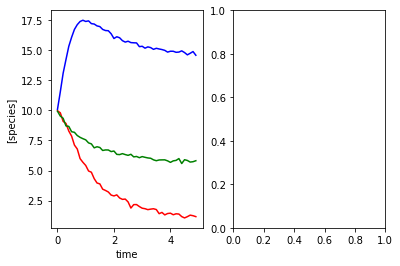

In [40]:
set_all_seeds(1234)

## SETUP MODEL
# establish size of model
num_species = 3
num_metabolites = 0

# construct interaction matrix
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15])
M[0, 2] = -0.1
M[2, 0] = 0.1

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu)
simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

# add some gaussian noise
yobs_x = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
plot_gMLV(yobs_x, sobs, times)

# add some gaussian noise on log scale
#yobs_lnx = np.log(yobs) + np.random.normal(loc=0, scale=0.01, size=yobs.shape)
#plot_gMLV(yobs_lnx, sobs, times)


In [ ]:
# Prior visualisation
# mu
x_mu = np.random.lognormal(0.01,0.5,size=10000)
plt.figure()
plt.hist(x_mu);
plt.title('mu')   

# Md
x_Md = np.random.normal(0.1,0.05,size=10000)
plt.figure()
plt.hist(x_Md);
plt.title('M[i,i]')    
    
# Shrinkage, M
tau0 = 0.001;
x_M = np.zeros([1000])
for i in range(1000):
    tau = np.random.standard_cauchy(size=1)
    lam = np.random.standard_cauchy(size=1)
    x_M[i] = np.random.normal(0,np.abs(lam)*np.abs(tau),size=1)
#print(x_M)
plt.figure()
plt.hist(x_M, range=(-5,5));
plt.title('M[i,j]');   

In [ ]:
# linearise
X, F = linearize_time_course_16S(yobs_x, times)

#print(X[:,:(X.shape[1]-1)])
X = X[:,:(X.shape[1]-1)]

import nest_asyncio
nest_asyncio.apply()
import stan

gLV_code = """
functions {
  vector lotka_volterra_N_red(real[] x, int N, vector mu, vector Md, vector M) {
     // Models Y = dlnX/dt = f ( X )
     
     vector[N] dydt;
     
     int countM = 1;
     
     for(i in 1:N){
        dydt[i] = mu[i] - Md[i]*x[i];
        
        for(j in 1:N){
            if ( i != j ){
                dydt[i] += M[countM]*x[j];
                countM += 1; 
                //print("loop iteration: ", i, j, countM);
             }
         }
     }
     
     return dydt;
  }

}

data {
  int<lower=1> N;
  int<lower=1> T;
  
  array[T,N] real y;
  array[T,N] real x;
  
  real sigma;

  //vector<lower=0>[N]  mu;
  //vector<lower=0>[N]  Md;
}

parameters {
  vector<lower=0>[N]  mu;
  vector<lower=0>[N]  Md;
  vector[N*N - N]     M;

  vector<lower=0>[N*N - N]  lambda;
  real<lower=0>  tau;
}

model {
  //target += normal_lpdf(mu | 1.0, 0.2);
  target += lognormal_lpdf(mu | 0.01, 0.5);
  
  target += normal_lpdf(Md | 0.1, 0.05);
  
  // Laplace
  //target += double_exponential_lpdf(M | 0, 0.1);

  // Horsehoe prior
  real tau0 = 0.001;
  target += cauchy_lpdf(tau | 0, tau0);

  for(i in 1:(N*(N-1))){
        target += normal_lpdf(M[i] | 0, lambda[i]*tau);
        target += cauchy_lpdf(lambda[i] | 0, 1);
  }

  for (t in 1:T) {
      vector[N] y_hat = lotka_volterra_N_red(x[t,:], N, mu, Md, M);
      for (s in 1:N){
        target += normal_lpdf(y[t,s] | y_hat[s], sigma);
      }
    }
}

"""

obs_data_lin = {"N": 3,
                "T": len(times)-1,   
                "y": F,
                "x": X,
                "sigma": 0.1,
                #"mu": mu,
                #"Md": np.array([-M[0,0],-M[1,1],-M[2,2]]),
                } 

posterior = stan.build(gLV_code, data=obs_data_lin, random_seed=1)

In [ ]:
sample_kwargs = {"num_samples": 1000, "num_chains": 2, "num_warmup": 5000 }
#fit = posterior.sample(num_chains=2, num_samples=500, num_warmup=10000, adapt={'delta':0.99})
fit = posterior.sample(**sample_kwargs)

#print(fit)

df = fit.to_frame()
print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
#post1 = np.random.normal(size=500)
#post2 = np.random.normal(size=500)
Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
istart = 0
iend = 2000

In [ ]:
print("mu:",mu)
for i in range(num_species):
    make_trace_plot("mu."+str(i+1),istart,iend)
    make_hist_plot("mu."+str(i+1),istart,iend)


print("Md:",M.diagonal())
for i in range(num_species):
    make_trace_plot("Md."+str(i+1),istart,iend)
    make_hist_plot("Md."+str(i+1),istart,iend)


for i in range( num_species*(num_species - 1)):
    make_trace_plot("M."+str(i+1),istart,iend)
    make_hist_plot("M."+str(i+1),istart,iend)


In [ ]:
# plot the fit using median values of parameters

post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)

# fill mu_h
#mu_h = mu # if mu is fixed
mu_h = est[0:num_species]
est = est[num_species:]

# fill M_h
M_h = np.zeros([num_species,num_species])
#np.fill_diagonal(M_h, M.diagonal() ) # if Md fixed
np.fill_diagonal(M_h, -est[0:num_species])
est = est[num_species:]

count = 0
print("est:", est)
for i in range(num_species):
    for j in range(num_species):
        if i != j:
            #M_h[i,j] = est[2*num_species + count]
            #M_h[i,j] = est[num_species + count]
            M_h[i,j] = est[count]
            count = count + 1

#print(mu_h)
#print(M_h)

# make the plot and comparison
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu,mu_h), M=(M, M_h))

## Single time course: three species, with perturbation


number of species: 3
specific growth rates: [0.98181944 1.99152092 0.6754225 ]
interaction matrix: 
[[-0.05  0.   -0.1 ]
 [ 0.   -0.1   0.  ]
 [ 0.1   0.   -0.15]]
metabolite production: 
None
perturbation matrix: 
[[ 0]
 [ 0]
 [-1]]
signal matrix:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]


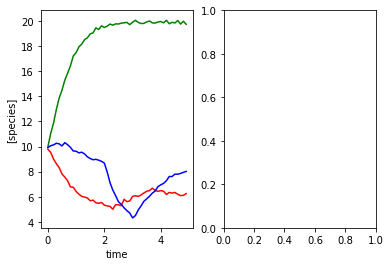

In [41]:
## SETUP MODEL
# establish size of model
num_species = 3
num_metabolites = 0

# construct interaction matrix
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15])
M[0, 2] = -0.1
M[2, 0] = 0.1

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# perturbation
tp = [[2,3]]
# construct perturbation matrix
E = np.array([[0, 0, -1]]).T

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     num_perturbations=1,
                     M=M,
                     mu=mu,
                     epsilon=E)

simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times, 
                                               sy0=np.hstack((init_species, init_metabolites)), 
                                               tp=tp)

# add some gaussian noise
yobs_x = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
plot_gMLV(yobs_x, sobs, times)

# calculate signal matrix
npert = 1
u = np.zeros([npert,len(times)])
for i in range(npert):
    ui = (times >= 2) & (times < 3) 
    #ui = ui.astype(int)
    u[i,:] = ui

# remove last column of signal matrix
u = u[:,:(u.shape[1]-1)]

print('signal matrix:\n', u)


In [42]:
# linearise
X, F = linearize_time_course_16S(yobs_x, times)

#print(X[:,:(X.shape[1]-1)])
X = X[:,:(X.shape[1]-1)]

import nest_asyncio
nest_asyncio.apply()
import stan

gLV_code = """
functions {
  vector lotka_volterra_N_red(real[] x, int N, vector mu, vector Md, vector M, vector E, real u) {
     // Model: F = dlnX/dt = mu + M x + E u
     
     vector[N] F;
     
     int countM = 1;
     
     for(i in 1:N){
        F[i] = mu[i] - Md[i]*x[i];
     
        // off diagonal interaction terms 
        for(j in 1:N){
            if ( i != j ){
                F[i] += M[countM]*x[j];
                countM += 1; 
                //print("loop iteration: ", i, j, countM);
             }
         }
     
         // epsilon terms
         F[i] += E[i]*u;
     }
     
     return F;
  }

}

data {
  int<lower=1> N;
  int<lower=1> T;
  int<lower=0> Np;
  
  array[T,N]  real y;
  array[T,N]  real x;
  array[T,Np] real u;
  
  real sigma;

  //vector<lower=0>[N]  mu;
  //vector<lower=0>[N]  Md;
}

parameters {
  vector<lower=0>[N]  mu;
  vector<lower=0>[N]  Md;
  vector[N*N - N]     M;
  vector[N]           E;

  vector<lower=0>[N*N - N]  lambda;
  real<lower=0>  tau;
}

model {
  target += lognormal_lpdf(mu | 0.01, 0.5);
  target += normal_lpdf(Md | 0.1, 0.05);
  target += normal_lpdf(E | 0, 0.5);
  
  // Horsehoe prior
  real tau0 = 0.001;
  target += cauchy_lpdf(tau | 0, tau0);
  
  for(i in 1:(N*(N-1))){
        target += normal_lpdf(M[i] | 0, lambda[i]*tau);
        target += cauchy_lpdf(lambda[i] | 0, 1);
  }
  //

  for (t in 1:T) {
      vector[N] y_hat = lotka_volterra_N_red(x[t,:], N, mu, Md, M, E, u[t,1] );
      for (s in 1:N){
        target += normal_lpdf(y[t,s] | y_hat[s], sigma);
      }
    }
}

"""

obs_data_lin = {"N": 3,
                "T": len(times)-1,   
                "Np": 1,
                "y": F,
                "x": X,
                "u": u.T,
                "sigma": 0.1,
                #"mu": mu,
                #"Md": np.array([-M[0,0],-M[1,1],-M[2,2]]),
                } 

posterior = stan.build(gLV_code, data=obs_data_lin, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/d0/x63k438154b57fhf8cw2n7n00000gn/T/httpstan_rbll65qu/model_avm5sk35.stan', line 3, column 30: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc


In [43]:
sample_kwargs = {"num_samples": 1000, "num_chains": 2, "num_warmup": 5000 }
#fit = posterior.sample(num_chains=2, num_samples=500, num_warmup=10000, adapt={'delta':0.99})
fit = posterior.sample(**sample_kwargs)

#print(fit)

df = fit.to_frame()
print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
#post1 = np.random.normal(size=500)
#post2 = np.random.normal(size=500)
Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
istart = 0
iend = 2000

Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400

                count        mean         std        min         25%  \
parameters                                                             
lp__           2000.0  -24.643632    3.907988 -39.908588  -27.052117   
accept_stat__  2000.0    0.930393    0.115272   0.007455    0.922864   
stepsize__     2000.0    0.015284    0.002242   0.013042    0.013042   
treedepth__    2000.0    7.672000    0.650867   3.000000    7.000000   
n_leapfrog__   2000.0  269.725500  124.426806  13.000000  255.000000   
divergent__    2000.0    0.034000    0.181274   0.000000    0.000000   
energy__       2000.0   35.595082    5.088797  20.382447   32.174889   
mu.1           2000.0    1.346961    0.461629   0.374598    1.014104   
mu.2           2000.0    1.876942    0.256042   0.734677    1.741026   
mu.3           2000.0    1.239110    0.545307   0.331562    0.796567   
Md.1           2000.0    0.092329    0.028865   0.018480    0.071818   
Md.2           2000.0    0.094966    0.008437   0.062806    0.08

mu_hat/mu:
[1.20297825 1.88670361 1.02914913]
[0.98181944 1.99152092 0.6754225 ]

M_hat/M:
[[-0.09 -0.01 -0.09]
 [ 0.   -0.1   0.  ]
 [ 0.06 -0.01 -0.15]]

 [[-0.05  0.   -0.1 ]
 [ 0.   -0.1   0.  ]
 [ 0.1   0.   -0.15]]

e_hat/e:
[[ 0.  ]
 [ 0.01]
 [-1.02]]

 [[ 0]
 [ 0]
 [-1]]


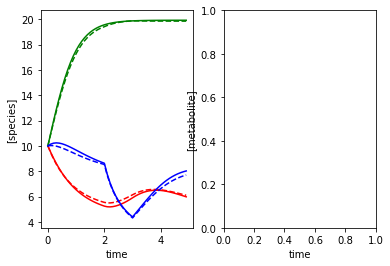

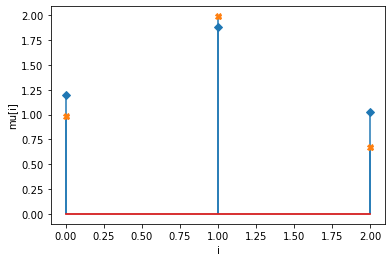

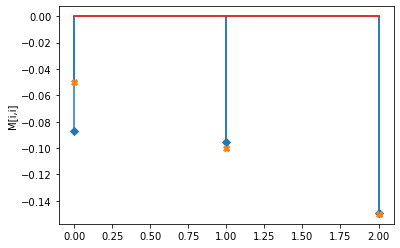

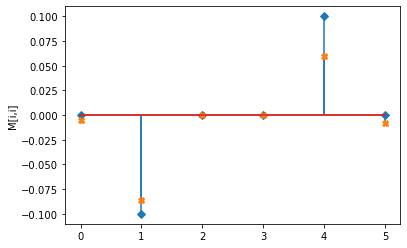

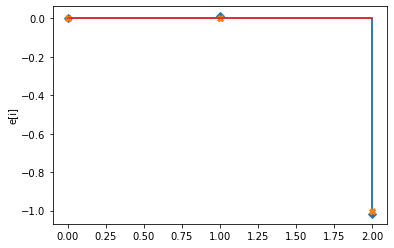

In [50]:
# plot the fit using median values of parameters

post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)

# fill mu_h
#mu_h = mu # if mu is fixed
mu_h = est[0:num_species]
est = est[num_species:]

# fill M_h
M_h = np.zeros([num_species,num_species])
#np.fill_diagonal(M_h, M.diagonal() ) # if Md fixed
np.fill_diagonal(M_h, -est[0:num_species])
est = est[num_species:]

count = 0
#print("est:", est)
for i in range(num_species):
    for j in range(num_species):
        if i != j:
            #M_h[i,j] = est[2*num_species + count]
            #M_h[i,j] = est[num_species + count]
            M_h[i,j] = est[count]
            count = count + 1

est = est[num_species*(num_species-1):]
#print(mu_h)
#print(M_h)

# fill E_h
E_h = np.reshape(est[0:num_species],(3,1))

# make the plot and comparison
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     num_perturbations=1,
                     M=M_h,
                     mu=mu_h,
                     epsilon=E_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)), tp=tp)

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu,mu_h), M=(M, M_h), e=(E, E_h))

## Single time course: ten species, no perturbation

In [ ]:
set_all_seeds(1234)

## SETUP MODEL
# establish size of model
num_species = 10
num_metabolites = 0

# construct interaction matrix
#TODO do this programmatically
M = np.zeros((num_species, num_species))

#np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2, -0.05, -0.1, -0.15, -0.01, -0.2])
np.fill_diagonal(M, -np.round( np.abs( np.random.normal(0.1, 0.05, size=num_species ) ), decimals=2) )

M[0, 2] = -0.025
M[1, 3] = 0.05
M[2, 9] = -0.05
M[4, 0] = 0.02
M[5, 2] = 0.02
M[8, 6] = -0.05

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu) #, epsilon=epsilon)
simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times, 
                                               sy0=np.hstack((init_species, init_metabolites)) ) 

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
print(yobs.shape)
# plot simulation
plot_gMLV(yobs, sobs, times)

In [ ]:
# linearise
X, F = linearize_time_course_16S(yobs, times)
#print(X[:,:(X.shape[1]-1)])
X = X[:,:(X.shape[1]-1)]

# time dependent perturbation
u = (times >= 2) & (times < 3) 
u = u.astype(int)
u = u[:len(u)-1]
print('perturbation:\n', u)


In [ ]:
# Horseshoe prior: work out choice for t0
D = (10*10)-10
p0 = 6
n = 50
sigma = 0.1
print( get_horseshoe_tau(p0,D,sigma,n) )

In [ ]:
import nest_asyncio
nest_asyncio.apply()
import stan

gLV_code = """
functions {
  vector lotka_volterra_N_red_u(real[] x, real[] u, int N, vector mu, vector Md, vector M, vector eps) {
     // Models Y = dlnX/dt = f ( X )
     
     vector[N] dydt;
     
     int countM = 1;
     
     for(i in 1:N){
        dydt[i] = mu[i] - Md[i]*x[i];
        
        for(j in 1:N){
            if ( i != j ){
                dydt[i] += M[countM]*x[j];
                countM += 1; 
                //print("loop iteration: ", i, j, countM);
             }
         }
     }
     
     return dydt;
  }

  vector lotka_volterra_N_red(real[] x, int N, vector mu, vector Md, vector M) {
     // Models Y = dlnX/dt = f ( X )
     
     vector[N] dydt;
     
     int countM = 1;
     
     for(i in 1:N){
        dydt[i] = mu[i] - Md[i]*x[i];
        
        for(j in 1:N){
            if ( i != j ){
                dydt[i] += M[countM]*x[j];
                countM += 1; 
                //print("loop iteration: ", i, j, countM);
             }
         }
     }
     
     return dydt;
  }

}

data {
  int<lower=1> N;
  int<lower=1> T;
  
  array[T,N] real y;
  array[T,N] real x;
  
  real sigma;

  //vector<lower=0>[N]  mu;
  //vector<lower=0>[N]  Md;
}

parameters {
  vector<lower=0>[N]  mu;
  vector<lower=0>[N]  Md;
  vector[N*N - N]     M;

  vector<lower=0>[N*N - N]  lambda;
  real<lower=0>  tau;
}

model {
  //target += normal_lpdf(mu | 1.0, 0.2);
  target += lognormal_lpdf(mu | 0.01, 0.5);
  
  target += normal_lpdf(Md | 0.1, 0.05);
  
  // Laplace
  //target += double_exponential_lpdf(M | 0, 0.1);

  // Horsehoe prior
  real tau0 = 0.001;
  //real tau0 = 0.01;
  target += cauchy_lpdf(tau | 0, tau0);

  for(i in 1:(N*(N-1))){
        target += normal_lpdf(M[i] | 0, lambda[i]*tau);
        target += cauchy_lpdf(lambda[i] | 0, 1);
  }

  for (t in 1:T) {
      vector[N] y_hat = lotka_volterra_N_red(x[t,:], N, mu, Md, M);
      for (s in 1:N){
        target += normal_lpdf(y[t,s] | y_hat[s], sigma);
      }
    }
}

"""

obs_data_lin = {"N": 10,
                "T": len(times)-1,   
                "y": F,
                "x": X,
                "sigma": 0.1,
                #"mu": mu,
                #"Md": np.array([-M[0,0],-M[1,1],-M[2,2]]),
                } 

posterior = stan.build(gLV_code, data=obs_data_lin, random_seed=1)

In [ ]:
sample_kwargs = {"num_samples": 1000, "num_chains": 2, "num_warmup": 5000 }
fit = posterior.sample(**sample_kwargs)

#print(fit)

df = fit.to_frame()
print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
#post1 = np.random.normal(size=500)
#post2 = np.random.normal(size=500)

Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
print("max Rhat:", np.max(Rhat))
istart = 0
iend = 2000

In [ ]:
# plot the fit using median values of parameters

post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)

# fill mu_h
#mu_h = mu # if mu is fixed
mu_h = est[0:num_species]
est = est[num_species:]

# fill M_h
M_h = np.zeros([num_species,num_species])
#np.fill_diagonal(M_h, M.diagonal() ) # if Md fixed
np.fill_diagonal(M_h, -est[0:num_species])
est = est[num_species:]

count = 0
#print("est:", est)
for i in range(num_species):
    for j in range(num_species):
        if i != j:
            #M_h[i,j] = est[2*num_species + count]
            #M_h[i,j] = est[num_species + count]
            M_h[i,j] = est[count]
            count = count + 1

#print(mu_h)
#print(M_h)

# make the plot and comparison
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu,mu_h), M=(M, M_h))